In [3]:
!pip install cpi

In [ ]:
# IMPORTS
import numpy as np
import pandas as pd
import cpi
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#load data
bls_cpi_df = cpi.series.get(seasonally_adjusted=False).to_dataframe()

In [107]:
bls_cpi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1453 entries, 0 to 1452
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   series_id            1453 non-null   object 
 1   year                 1453 non-null   int64  
 2   date                 1453 non-null   object 
 3   value                1453 non-null   float64
 4   period_id            1453 non-null   object 
 5   period_code          1453 non-null   object 
 6   period_abbreviation  1453 non-null   object 
 7   period_name          1453 non-null   object 
 8   period_month         1453 non-null   int64  
 9   period_type          1453 non-null   object 
dtypes: float64(1), int64(2), object(7)
memory usage: 113.6+ KB


In [108]:
bls_cpi_df = bls_cpi_df[bls_cpi_df['period_type']=='monthly']
bls_cpi_df['date'] = pd.to_datetime(bls_cpi_df['date'])
bls_cpi_df = bls_cpi_df.set_index('date')

In [153]:
bls_cpi_df = bls_cpi_df.sort_index().loc['2015':'2023', :] 

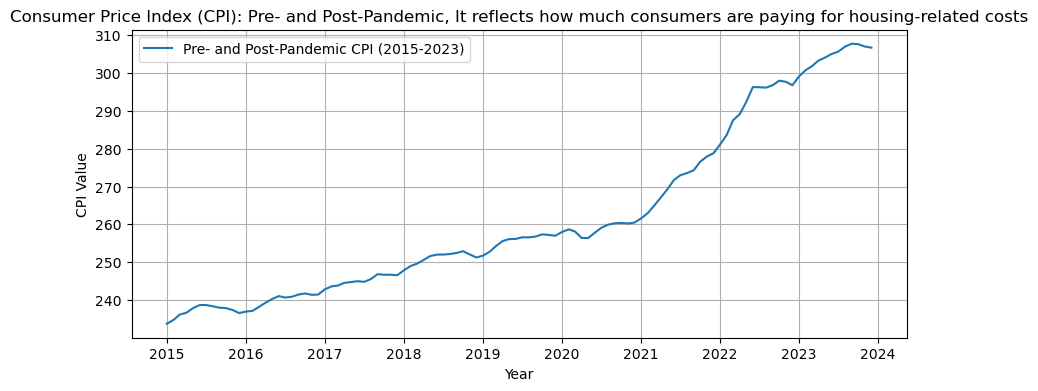

In [154]:
fig = plt.figure(figsize=(10, 4))
#bls_cpi_df['value'].loc['2015':'2024'].plot(figsize=(10,4))
plt.plot(bls_cpi_df['value'].loc['2015':'2023'], label='Pre- and Post-Pandemic CPI (2015-2023)')
plt.title("Consumer Price Index (CPI): Pre- and Post-Pandemic, It reflects how much consumers are paying for housing-related costs")
plt.xlabel("Year")
plt.ylabel("CPI Value")
plt.legend()
plt.grid(True)

In [155]:
def len_periods(df, beginning, end):
    return len(df[(beginning <= df['year']) & (df['year'] <= end)].nunique())

In [ ]:
#Targeting a 2% inflation rate since 2015, add a line to same plot to starting with the 2015 value
start = bls_cpi_df['value'].loc['2015':'2023'].iloc[0]

periods = len_periods(bls_cpi_df, 2015, 2023)

In [157]:
start, periods

(233.707, 9)

In [158]:
#add function that calculates the 2% inflation rate
def get_target_cpi(previous_cpi):
    return previous_cpi + 0.02*(previous_cpi)

In [159]:
target_cpis = [start]
for year in range(0,periods):
    target_cpis.append(get_target_cpi(target_cpis[year]))

In [160]:
target_cpis

[233.707,
 238.38114,
 243.1487628,
 248.01173805599998,
 252.97197281712,
 258.03141227346237,
 263.1920405189316,
 268.4558813293102,
 273.82499895589643,
 279.30149893501437]

In [161]:
dates = pd.date_range('2015-01-01','2023-12-31',periods=periods+1)
target_cpi_series = pd.Series(data =target_cpis, index= dates)

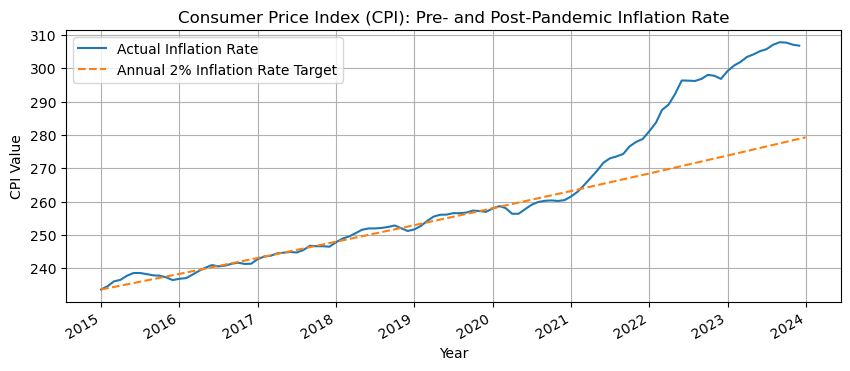

In [181]:
""" fig = plt.figure(dpi=100)
bls_cpi_df['value'].loc['2015':'2024'].plot(figsize=(10,4))
target_cpi_series.plot(ls='--') 
plt.xlabel('Date')
plt.ylabel('CPI Value')
 """
fig = plt.figure(figsize=(10, 4))
plt.plot(bls_cpi_df['value'].loc['2015':'2023'], label='Actual Inflation Rate')
target_cpi_series.plot(ls='--', label='Annual 2% Inflation Rate Target') 
plt.title("Consumer Price Index (CPI): Pre- and Post-Pandemic Inflation Rate")
plt.xlabel("Year")
plt.ylabel("CPI Value")
plt.legend()
plt.grid(True)




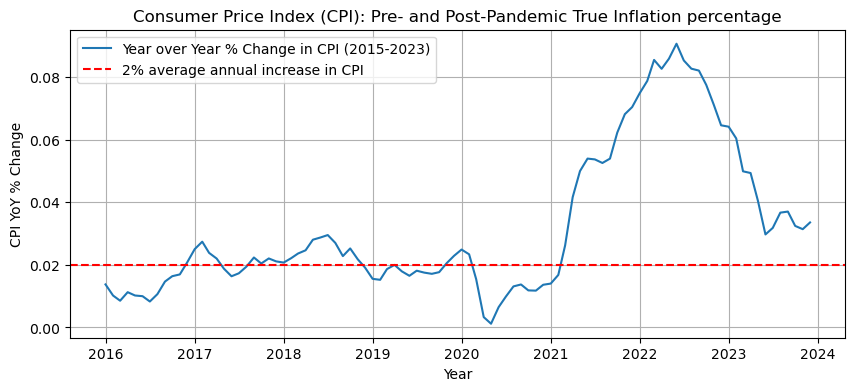

In [183]:
fig = plt.figure(figsize=(10, 4))
plt.plot(bls_cpi_df['value'].loc['2015':'2023'].pct_change(12), label='Year over Year % Change in CPI (2015-2023)')
plt.axhline(0.02,ls='--',c='red',label='2% average annual increase in CPI')
plt.title("Consumer Price Index (CPI): Pre- and Post-Pandemic True Inflation percentage")
plt.xlabel("Year")
plt.ylabel("CPI YoY % Change")
plt.legend()
plt.grid(True)